# Data Preprocessing

Import all needed packages

In [506]:
import pandas as pd
import numpy as np 
import missingno as msno
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from pandas.core.dtypes.common import is_datetime64_dtype as is_datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from difflib import SequenceMatcher
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split



Set the maximum numbers of a DataFrame print (e.g. `print(dataframe)`)

In [507]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

Load all needed dataframes

In [508]:
t1 = pd.read_csv('../Data Files/HHS_T1_20_10_21.csv', sep=',')
t1_eindhoven = pd.read_csv('../Data Files/TOTAAL_T1_20-21_Eindhoven.csv')
t0 = pd.read_csv('../Data Files/T0 data/T0_motoric_new.csv', sep=';')
postcodes_dh_rot = pd.read_csv('../Data Files/Copy of Scholen met postcodesDH_Rot.csv')
postcodes_gro = pd.read_csv('../Data Files/Copy of Scholen met postcodesGRO.csv')
questionaires = pd.read_excel('../Data Files/T0 data/Updated_questionaire.xlsx')
df_cbs_core_numbers = pd.read_csv('Data-Files/Raw_data/CBS_core_numbers.csv')
df_cbs_gender_age = pd.read_csv('Data-Files/Raw_data/CBS_gender_age.csv')
df_cbs_income = pd.read_csv('Data-Files/Raw_data/CBS_income.csv')
df_cbs_migration = pd.read_csv('Data-Files/Raw_data/CBS_migration_background.csv')


df_dict = {'t0': t0, 't1':t1, 't1 eindhoven': t1_eindhoven, 'questionaires': questionaires, 'postcodes dh rot': postcodes_dh_rot, 'postcodes gro': postcodes_gro, 'cbs core numbers': df_cbs_core_numbers, 'cbs gender age': df_cbs_gender_age, 'cbs income': df_cbs_income, 'cbs migration background': df_cbs_migration}


Function for getting insights in a dataframe

In [509]:
def printDataframeInsights(df):
    print('Shape of Dataframe: ', df.shape)
    print('\n Dataframe Size: ', df.size)
    print('\n Dataframe Info: \n', df.info(verbose=True, show_counts=True))
    print('\n Dataframe Head: \n', df.head())
    print('\n Dataframe Describe: \n', df.describe())
    print('\n IsNa: \n', df.isna().sum())

Converts datetime object into object

In [510]:
def convertDatetimeToObject(df):
    for col in df.columns:
        if is_datetime(df[col]):
            print(col)
            df[col] = df[col].astype(object)
    return df

Divide columns into a list containing numeric columns and a list containing object columns and return those

In [511]:

def getSubsetColumnsList(df):
    numeric_cols = []
    non_numeric_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            if pd.to_numeric(df[col], errors='coerce').notnull().sum() > (0.5*len(df)):
                numeric_cols.append(col)
            elif pd.to_numeric(df[col], errors='coerce').notnull().sum() < (0.5*len(df)):
                non_numeric_cols.append(col)

    return numeric_cols, non_numeric_cols 

### Clean columns
Remove strings from numeric columns and change datatype from object to numeric

In [512]:

def convertColumnTypes(cols_to_convert, df):
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

Method for saving names of columns with dtype == object in a list

In [513]:

def saveObjectColumnNameToList(df):
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical_cols.append(col)

    return categorical_cols   


Remove columns with only one unique value. To prevent invariance in features.

In [514]:
def identifyColumnWithSingleValueAndDrop(original_df):
    df = original_df.copy()
    column_dict = {}
    for col in df.columns:
        column_dict[col] = df[col].unique()
    for col in column_dict:
        if len(column_dict[col]) <= 2:
            df.drop(labels=col, axis=1, inplace=True)
            
    return df     


Search for object columns and append them in a list and return this list.

In [515]:
def convertColumnsList(df):
    cols_to_convert = []
    for col in df.columns:
        if df[col].dtype == 'object':
            if not 'Remark' in str(col) and not 'Unnamed' in str(col) and not 'Birth' in str(col) and not 'Geboort' in str(col):
                cols_to_convert.append(col)
    return cols_to_convert    

## Types

In [542]:
def encodeColumns(df):
    le = LabelEncoder()
    categorical_cols = saveObjectColumnNameToList(df)
    df[categorical_cols] = df[categorical_cols].apply(le.fit_transform)
    return df

In [523]:
def searchForDateColumns(df, dateFormat='%d%m%Y'): 
    for col in df.columns:
        if 'date' in col or 'datum' in col or 'Datum' in col:
            print(col)
            df[col] = pd.to_datetime(df[col], infer_datetime_format=True, format = dateFormat, errors='coerce')

    return df  

In [524]:
def deletePreviousDataFromDataframe(df, formerData):
    for col in df.columns:
        if formerData in col:
            df.drop(col, axis=1, inplace=True)
    return df     

### Removing outliers

As the target group for our study are only children from the age of 4 to 6 we can delete every child above this age. This has been done by `removeNotTargetGroup`

The function `removeOutliers` uses the 2* mean + std as upper limit and -2*mean - std as lower limit. Every value below the lower limit or above the upper limit gets replaced with a NaN for imputation.

The function `removeOutliersIQR` uses the interquartile Range method. This doesn't work for our dataset as there are many features with too much invariance. Therefore most of the times children with bad motor skills get deleted which isn't our goal.

The last function removes every feature with more than `percentage`*100 missing values as the imputation will select a random value below this percentage.

In [529]:
def removeNotTargetGroup(df, ageColumn, age):
    df.drop(df[df[ageColumn] > age].index, inplace=True)
    return df

In [516]:
def removeOutliers(original_df):
    df = original_df.copy()
    df_std = df.std()
    df_mean = df.mean()
    
    upper_limit = {}
    lower_limit = {}
    for col in df.columns:
        if not df[col].dtype == 'object' and not 'Respondent' in col and not 'Zip' in col and not 'code' in col and not df[col].dtype == 'datetime64[ns]' : 
            upper_limit[col] = 2*df_mean[col]+ df_std[col]
            lower_limit[col] = -2*df_mean[col] - df_std[col]

    for col in upper_limit.keys():
        for ind, row in df.iterrows():
            if df.loc[ind, col] > upper_limit[col] or df.loc[ind, col] < lower_limit[col]:
                df.loc[ind,col] = np.nan
    return df

In [517]:
def removeOutliersIQR(original_df):
    df = original_df.copy()
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    for col in q1.index:
        if q1[col] == q3[col]:
            q1.drop(labels=col, inplace=True)
            q3.drop(labels=col, inplace=True) 
    iqr = q3-q1
    lower_limit = q1-1.5*iqr
    upper_limit = q3+1.5*iqr

    for col in iqr.index:
        for ind, row in df.iterrows():
            if not df.loc[ind, col] > upper_limit[col] and not df.loc[ind, col] > lower_limit[col]:
                df.loc[ind, col] = np.nan
    return df 

In [528]:
# Remove columns where more than the half entries are missing and return new dataframe
# e.g. percentage = 0.2 = 20% 
# remove columns with more than 20% missing data
def removeColumnWithMissingEntries(df, percentage):
    df_without_missing_entries = df.copy()
    for col in df_without_missing_entries.columns:
        if df_without_missing_entries[col].isna().sum() >= (percentage * len(df)):
            df_without_missing_entries.drop(col, axis=1, inplace=True)
            
    return df_without_missing_entries

### Add data

The following functions calculate the MQ score with the formula (percentile/AST-Time) * 100, the MQ category, the MQ category binary and the BMI category. The percentile can be extracted from the paper Hoeboer 2018 (see Bibliography).

For the MQ and BMI category we received the syntax from our problem owner. Can be found in the Folder Logic.

MQ_categorie 1 = 'ernstige motorische achterstand' 2 = 'kleine motorische achterstand' 3 = 'normaal motorisch begaafd' 4 = 'goed motorisch begaafd' 5 = 'zeer hoog motorisch begaafd'

Every MQ category below 3 is classified as bad motor skills therefore the MQ category can be simplified into 0 = bad and 1 = good. 


In [518]:
def calculateMQScore(gender, age, ast):
    percentil_score = 0
    #boys
    if gender == 0:
        if age >= 4 and age < 7:
            if age >= 4 and age < 5:
                percentil_score = 31.35
            elif age >= 5 and age < 6:
                percentil_score = 24.7
            elif age >=6 and age < 7:
                percentil_score = 21.6
        elif age >= 7 and age < 10:
            if age >=7 and age < 8:
                percentil_score = 31.4
            elif age >=8 and age < 9:
                percentil_score = 28.6
            elif age >=9 and age < 10:
                percentil_score = 26.6
                

       
    #girls
    elif gender == 1:
        if age >= 4 and age < 7:    
            if age >=4 and age < 5:
                percentil_score = 31.7
            elif age >=5 and age < 6 and gender == 1:
                percentil_score = 26.3
            elif age >=6 and age < 7 and gender == 1:
                percentil_score = 23
        elif age >= 7 and age < 10:
            if age >=7 and age < 8:
                percentil_score = 34
            elif age >=8 and age < 9:
                percentil_score = 30.1
            elif age >=9 and age < 10: 
                percentil_score = 29       
    return np.round((percentil_score / ast) *100, 3) 

In [519]:
def calculateMQCategory(gender, ageOnTestday, mqScore):
    
    # BOYS
    if gender == 0 and ageOnTestday > 2.0 and ageOnTestday < 5:
        if mqScore > 0 and mqScore <= 72:
            return 1
        elif mqScore > 72 and mqScore <= 87:
            return 2
        elif mqScore > 87  and mqScore <= 115:
            return 3
        elif mqScore > 115 and mqScore <= 132:
            return 4
        elif mqScore > 132 and mqScore <= 300:
            return 5
        
    elif gender == 0 and ageOnTestday >= 5.0 and ageOnTestday < 6:
        if mqScore > 0 and mqScore <= 75:
            return 1
        elif mqScore > 75 and mqScore <= 86:
            return 2
        elif mqScore > 86  and mqScore <= 120:
            return 3
        elif mqScore > 120 and mqScore <= 143:
            return 4
        elif mqScore > 143 and mqScore <= 300:
            return 5 
        
    elif gender == 0 and ageOnTestday >= 6.0 and ageOnTestday < 10:
        if mqScore > 0 and mqScore <= 77:
            return 1
        elif mqScore > 77 and mqScore <= 87:
            return 2
        elif mqScore > 87  and mqScore <= 111:
            return 3
        elif mqScore > 111 and mqScore <= 125:
            return 4
        elif mqScore > 125 and mqScore <= 300:
            return 5 
     
    
    # GIRLS
    elif gender == 1 and ageOnTestday > 2.0 and ageOnTestday < 5:
        if mqScore > 0 and mqScore <= 69:
            return 1
        elif mqScore > 69 and mqScore <= 80:
            return 2
        elif mqScore > 80  and mqScore <= 113:
            return 3
        elif mqScore > 113 and mqScore <= 123:
            return 4
        elif mqScore > 123 and mqScore <= 300:
            return 5
        
    elif gender == 1 and ageOnTestday >= 5.0 and ageOnTestday < 6:
        if mqScore > 0 and mqScore <= 77:
            return 1
        elif mqScore > 77 and mqScore <= 88:
            return 2
        elif mqScore > 88  and mqScore <= 116:
            return 3
        elif mqScore > 116 and mqScore <= 129:
            return 4
        elif mqScore > 129 and mqScore <= 300:
            return 5 
        
    elif gender == 1 and ageOnTestday >= 6.0 and ageOnTestday < 10:
        if mqScore > 0 and mqScore <= 73:
            return 1
        elif mqScore > 73 and mqScore <= 87:
            return 2
        elif mqScore > 87  and mqScore <= 112:
            return 3
        elif mqScore > 112 and mqScore <= 125:
            return 4
        elif mqScore > 125 and mqScore <= 300:
            return 5 

In [520]:
def calculateBMICategory(gender, age, bmi):
    
    # BOYS
    if gender == 0 and age > 2.0 and age < 5:
        if bmi > 0 and bmi <= 17.54:
            return 1
        elif bmi > 17.55 and bmi <= 19.28:
            return 2
        elif bmi > 19.29:
            return 3
        
        
    elif gender == 0 and age >= 5.0 and age < 6:
        if bmi > 0 and bmi <= 17.41:
            return 1
        elif bmi > 17.42 and bmi <= 19.29:
            return 2
        elif bmi > 19.3:
            return 3
       
        
    elif gender == 0 and age >= 6.0 and age < 7:
        if bmi > 0 and bmi <= 17.54:
            return 1
        elif bmi > 17.55 and bmi <= 19.77:
            return 2
        elif bmi > 19.78:
            return 3
    
    elif gender == 0 and age <= 7 and age < 8:
        if bmi > 0 and bmi <= 17.91:
            return 1
        elif bmi >= 17.92 and bmi <= 20.62:
            return 2
        elif bmi >= 20.63:
            return 3
        
    # GIRLS    
    elif gender == 1 and age > 2.0 and age < 5:
        if bmi > 0 and bmi <= 17.27:
            return 1
        elif bmi > 17.28 and bmi <= 19.14:
            return 2
        elif bmi > 19.15:
            return 3
       
        
    elif gender == 1 and age >= 5.0 and age < 6:
        if bmi > 0 and bmi <= 17.14:
            return 1
        elif bmi > 17.14 and bmi <= 19.16:
            return 2
        elif bmi > 19.16:
            return 3
        
        
    elif gender == 1 and age >= 6.0 and age < 7:
        if bmi > 0 and bmi <= 17.33:
            return 1
        elif bmi > 17.33 and bmi <= 19.64:
            return 2
        elif bmi > 19.64 :
            return 3
        
    elif gender == 1 and age >= 7.0 and age < 8:
        if bmi > 0 and bmi <= 17.74:
            return 1
        elif bmi > 17.74 and bmi <= 20.5:
            return 2
        elif bmi > 20.5:
            return 3  

In [532]:
def calculateMQScoreCategoryAndBMICat(original_df, genderColumn, ageColumn, astTimeColumn, bmiColumn):
    df = original_df.copy()
    df['MQ'] = df.apply(lambda row: calculateMQScore(row[genderColumn], row[ageColumn], row[astTimeColumn]), axis=1)
    df['MQ category'] = df.apply(lambda row: calculateMQCategory(row[genderColumn], row[ageColumn], row['MQ']), axis=1)
    df['BMI category'] = df.apply(lambda row: calculateBMICategory(row[genderColumn], row[ageColumn], row[bmiColumn]), axis=1)
    df['MQ category binary'] = df.apply(lambda row: calculateMQCategoryBinary(row['MQ category']), axis=1)
    return df


## Merge

In [530]:
def calculateMQCategoryBinary(mq_cat):
    if mq_cat < 3:
        return 0
    elif mq_cat >= 3:
        return 1      

In [521]:
def mergeZipCodes(df, df_postcodes, respon_df1, respon_df_postcodes, end_respondent, origin_col1_df_postcodes, origin_col2_df_postcodes ):
    for t0_row in df.iterrows():
        for pc_row in range(0, (len(df_postcodes))):
    
            if pc_row <= len(df_postcodes)-2:
                if int(t0_row[1][respon_df1]) >= int(df_postcodes.loc[pc_row][respon_df_postcodes]) and int(t0_row[1][respon_df1]) < int(df_postcodes.loc[pc_row+1][respon_df_postcodes]):
                    df.at[t0_row[0], 'Zipcode-number'] = df_postcodes.loc[pc_row][origin_col1_df_postcodes]
                    df.at[t0_row[0], 'Zipcode-letters'] = str(df_postcodes.loc[pc_row][origin_col2_df_postcodes])
            
            elif pc_row == len(df_postcodes)-1:
                if int(t0_row[1][respon_df1]) >= int(df_postcodes.loc[pc_row][respon_df_postcodes]) and int(t0_row[1][respon_df1]) < end_respondent:
                    df.at[t0_row[0], 'Zipcode-number'] = df_postcodes.loc[pc_row][origin_col1_df_postcodes]
                    df.at[t0_row[0], 'Zipcode-letters'] = str(df_postcodes.loc[pc_row][origin_col2_df_postcodes])
                    
    return df

In [522]:
def mergeDHRotGroZipcodes(original_df, df_postcodes_dh_rot, df_postcodes_gro, respon_df1, end_respondent, origin_col1_df_postcodes, origin_col2_df_postcodes):
    df = original_df.copy()
    df['Zipcode-number'] = np.nan
    df['Zipcode-letters'] = None
    df = mergeZipCodes(df, df_postcodes_dh_rot, respon_df1, end_respondent, df_postcodes_dh_rot.loc[0][end_respondent], origin_col1_df_postcodes, origin_col2_df_postcodes)
    df = mergeZipCodes(df, df_postcodes_gro, respon_df1, end_respondent, df.iloc[-1]['Respondentnummer'], origin_col1_df_postcodes, origin_col2_df_postcodes)
    df_without_nan = df.dropna()
    return df, df_without_nan

In [525]:
def similar(a, col_df, df):
    if SequenceMatcher(None, a, col_df).ratio() > 0.8:
        df.rename(columns={col_df: a}, inplace=True)
    return df 

In [526]:
def getGenderAgeBmiColumnNamesDict(df):
    column_dict = {}
    for col in df.columns:
        if 'Gender' in col or 'Geslacht' in col:
            column_dict['Gender'] = col
        elif 'Leeftijd' in col or 'Age' in col:
            column_dict['Age'] = col
        elif 'BMI' in col:
            column_dict['BMI'] = col
    return column_dict        


In [527]:
def getNewestASTTest(df):
    col_list = df.columns.to_list()
    astNumbers = []
    for col in col_list:
        if 'AST-' in col:
            astString = col.split('-')
            astNumbers.append(int(astString[1].split(' ')[0]))
        elif 'AST ' in col:
            return col    
    astNumbers.sort(reverse=True)
    for col in col_list:
        if 'AST-'+str(astNumbers[0]) in col:
            return col

## Split data

In [531]:
# Splitting
def Split(Data, y, column, isBinary=False, isT0=False):
    
    
    if isT0:
        Data = Data.drop(Data.columns[[0,1,4]], axis=1)
    if isBinary:
        X = Data.drop(columns=['MQ category'])
        y = Data[column].values
    elif not isBinary: 
        X = Data.drop(labels='MQ category binary', axis=1)   
    X = X.drop(column, axis = 1)
    col_names = X.columns.to_list()

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2 ,random_state= 1, shuffle=True) 
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state= 1, shuffle=True )

    return X_test, y_test, X_train, y_train, X_val, y_val, col_names

## Preproccessing function

Below is the major preprocessing function where insights for the dataframe are printed. In this function I remove columns with invariance, convert column types, remove outliers, calculate the MQ-Score, MQ-Category, MQ-Category binary and the BMI-Category. In the end we get 5 different dataframes. `df`, `df_mean_outliers` and `df_iqr_outliers` are the dataframes we need for imputation. 

In [533]:
# Cleaning method
def preprocessing(df, age, genderColumn, ageColumn, astColumn, bmiColumn):
    printDataframeInsights(df)
    df = identifyColumnWithSingleValueAndDrop(df)
    cols_to_convert = convertColumnsList(df)
    df = convertColumnTypes(cols_to_convert, df)
    df = removeNotTargetGroup(df, ageColumn, age)
    df = calculateMQScoreCategoryAndBMICat(df, genderColumn, ageColumn, astColumn, bmiColumn) # insert column names
    df = removeColumnWithMissingEntries(df, percentage) 
    df_mean_outliers = removeOutliers(df) 
    df_iqr_outliers = removeOutliersIQR(df)
    df_mean_outliers_wo_nan = df_mean_outliers.dropna()
    df_iqr_outliers_wo_nan = df_iqr_outliers.dropna()
    return df,df_mean_outliers, df_iqr_outliers, df_mean_outliers_wo_nan, df_iqr_outliers_wo_nan

## Insights
Below you can see that cbs data is too complex and the postcodes have a one-to-many relationship.

In [534]:
print(df_cbs_migration[df_cbs_migration['Postcode'] == '1011'])

        Unnamed: 0       ID                  Geslacht  \
4               70       70  Totaal mannen en vrouwen   
5               71       71  Totaal mannen en vrouwen   
8156         97894    97894  Totaal mannen en vrouwen   
8157         97895    97895  Totaal mannen en vrouwen   
16308       195718   195718  Totaal mannen en vrouwen   
16309       195719   195719  Totaal mannen en vrouwen   
24460       293542   293542  Totaal mannen en vrouwen   
24461       293543   293543  Totaal mannen en vrouwen   
32612       391366   391366  Totaal mannen en vrouwen   
32613       391367   391367  Totaal mannen en vrouwen   
40764       489190   489190  Totaal mannen en vrouwen   
40765       489191   489191  Totaal mannen en vrouwen   
48916       587014   587014  Totaal mannen en vrouwen   
48917       587015   587015  Totaal mannen en vrouwen   
57068       684838   684838  Totaal mannen en vrouwen   
57069       684839   684839  Totaal mannen en vrouwen   
65220       782662   782662  To

### Plot missing values

To get insights into our data I plotted the missing values using the missingno matrix. The plots show very clearly that there are many holes in the received datasets.

Shape of Dataframe:  (1708, 34)

 Dataframe Size:  58072
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708 entries, 0 to 1707
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondentnummer              1708 non-null   int64  
 1   Gender                        1707 non-null   float64
 2   IC                            1708 non-null   int64  
 3   Geboortedatum                 1672 non-null   object 
 4   Leeftijd (op testdag)         1675 non-null   float64
 5   AST (tijd afgerond op 0.1s)   1608 non-null   float64
 6   Opmerkingen                   46 non-null     object 
 7   Lengte (afgerond op 0.1 cm)   1631 non-null   float64
 8   Gewicht (afgerond op 0.1 kg)  1630 non-null   float64
 9   Lengte (in m)                 1631 non-null   float64
 10  BMI                           1630 non-null   float64
 11  Gymles                        1561 non-null   float64
 12  Zweml

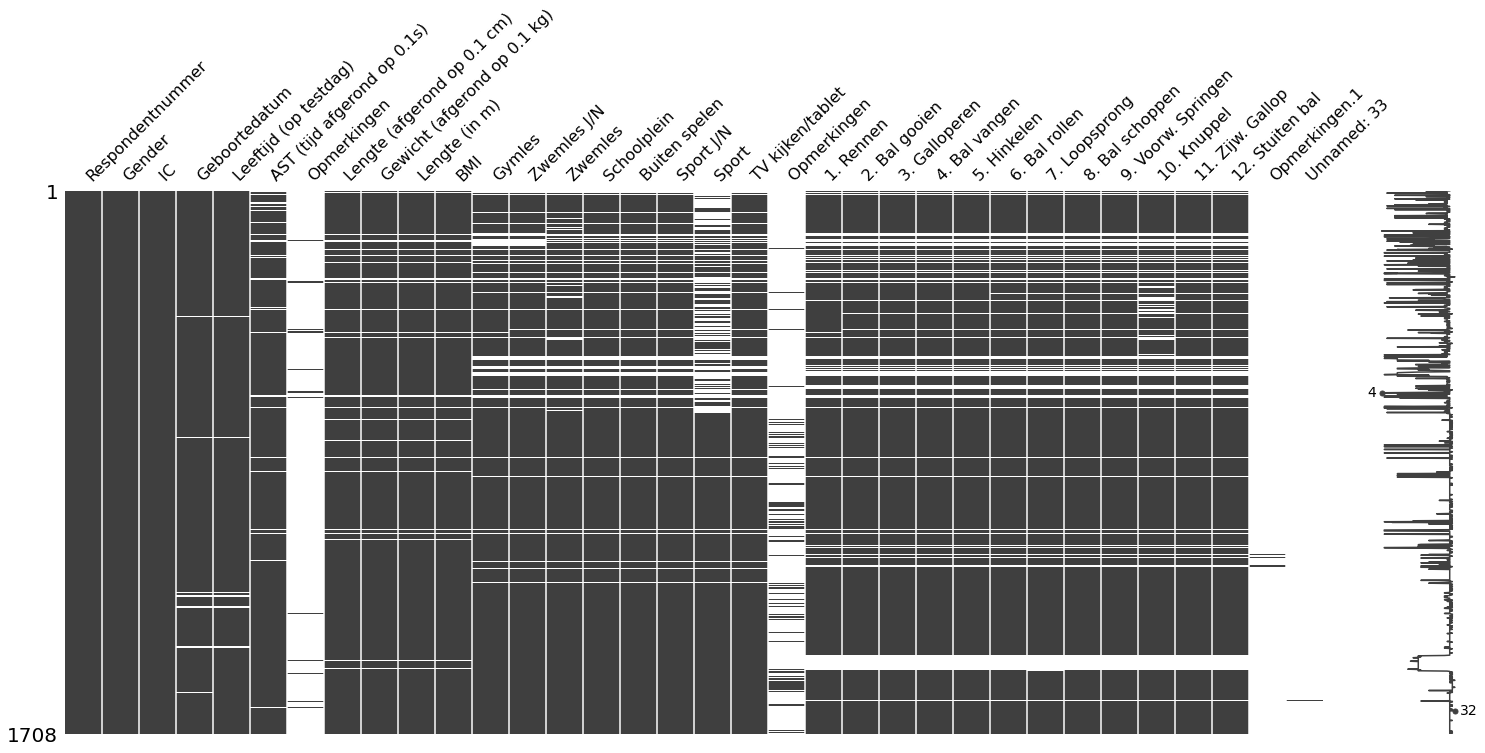

Shape of Dataframe:  (733, 36)

 Dataframe Size:  26388
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Respondentnummer               731 non-null    float64
 1   Geslacht                       730 non-null    object 
 2   IC                             728 non-null    float64
 3   Geboortedatum                  725 non-null    object 
 4   Leeftijd op testdag            696 non-null    object 
 5   AST-1 (tijd afgerond op 0,1s)  471 non-null    object 
 6   AST-2 (tijd afgerond op 0,1s)  159 non-null    float64
 7   MQ score                       624 non-null    float64
 8   Opmerkingen                    14 non-null     object 
 9   Lengte (afgerond op 0,1 cm)    629 non-null    float64
 10  Gewicht (afgerond op 0,1 kg)   629 non-null    float64
 11  lengte (m)                     630 non-null    float64

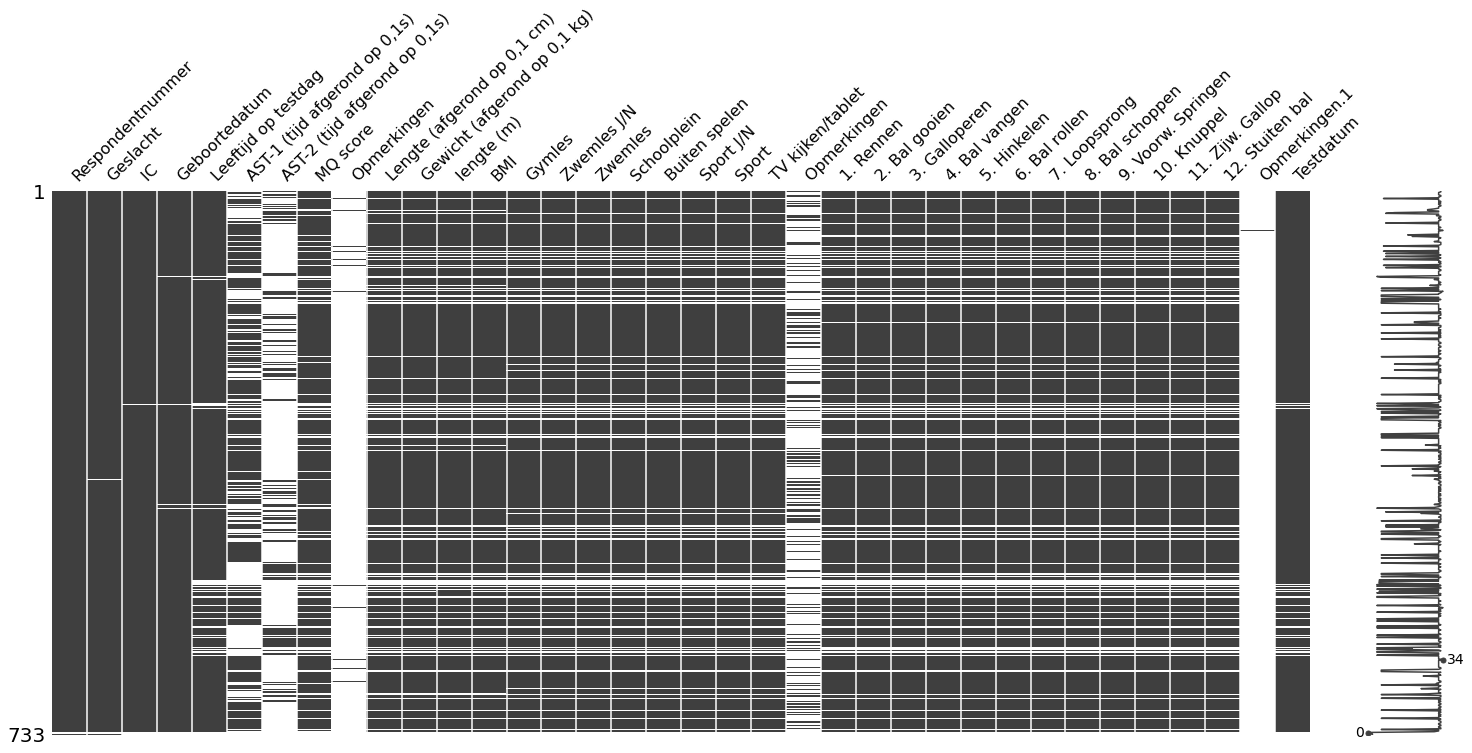

Shape of Dataframe:  (2649, 51)

 Dataframe Size:  135099
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2649 entries, 0 to 2648
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Respondentnummer           2649 non-null   int64 
 1   Respondentnummer_nieuw     2649 non-null   int64 
 2   Tijdsperiode               2649 non-null   object
 3   Schoolnummer               2649 non-null   object
 4   Geboortedatum              2649 non-null   object
 5   gebdat_kind_VL_T0          2649 non-null   object
 6   Geboortedatum_opgevuld_T0  2649 non-null   object
 7   Geslacht                   2649 non-null   object
 8   ICWP1                      884 non-null    object
 9   IC                         872 non-null    object
 10  Klas                       1551 non-null   object
 11  Groep                      2649 non-null   object
 12  ASTtijdafgerondop01s       2649 non-null   object
 13  Datum

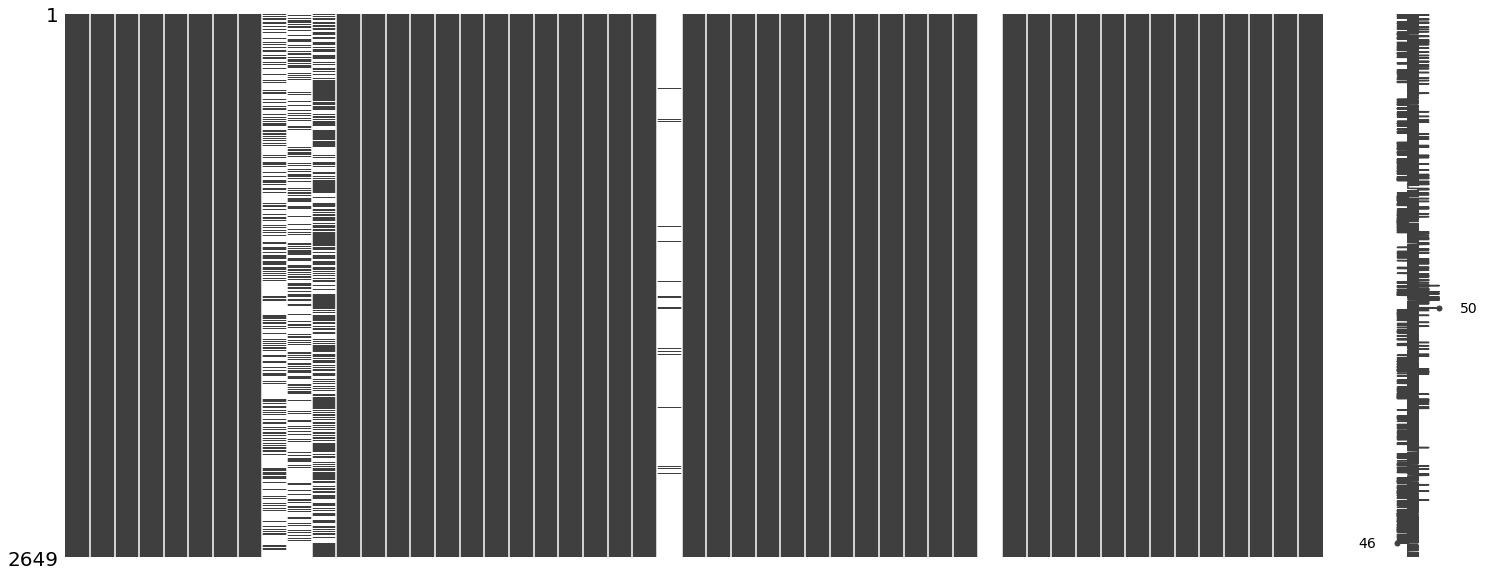

Shape of Dataframe:  (1102, 92)

 Dataframe Size:  101384
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 92 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   respondentnummer                     1102 non-null   int64  
 1   who_filled_in                        954 non-null    float64
 2   composition                          876 non-null    float64
 3   other_location                       954 non-null    float64
 4   country_of_birth_child               954 non-null    float64
 5   country_of_birth_parent              947 non-null    float64
 6   country_of_birth_partner             932 non-null    float64
 7   education_parent                     949 non-null    float64
 8   education_partner                    929 non-null    float64
 9   cult_background_parent               950 non-null    float64
 10  cult_background_partner              9

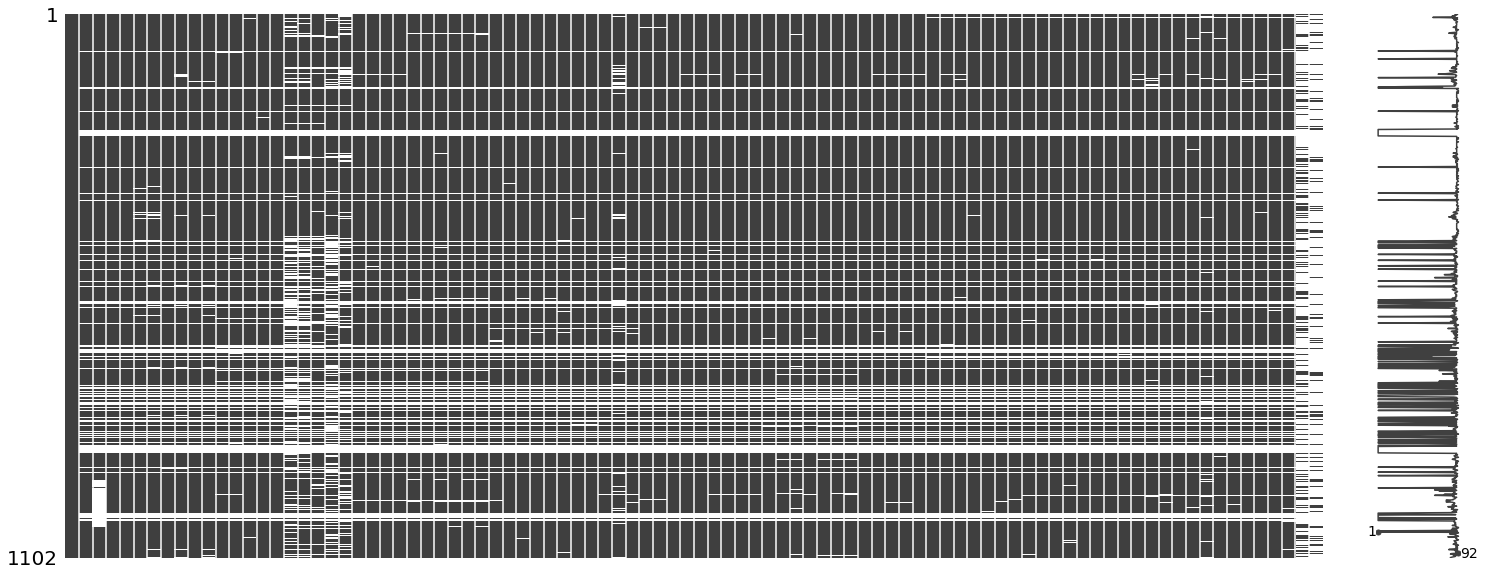

Shape of Dataframe:  (16, 6)

 Dataframe Size:  96
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Den Haag - Rotterdam     16 non-null     object 
 1   Adres                    16 non-null     object 
 2   Postcode number          16 non-null     int64  
 3   Postcode letters         16 non-null     object 
 4   Column3                  0 non-null      float64
 5   Respondentnummer vanaf:  16 non-null     int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 896.0+ bytes

 Dataframe Info: 
 None

 Dataframe Head: 
                   Den Haag - Rotterdam  \
0                           De Plevier   
1                      OBS De Triangel   
2                        OBS De Klimop   
3  Dalton Kind Centrum Helen Parkhurst   
4                       IBS Er Riseleh   

                                        Adres  Pos

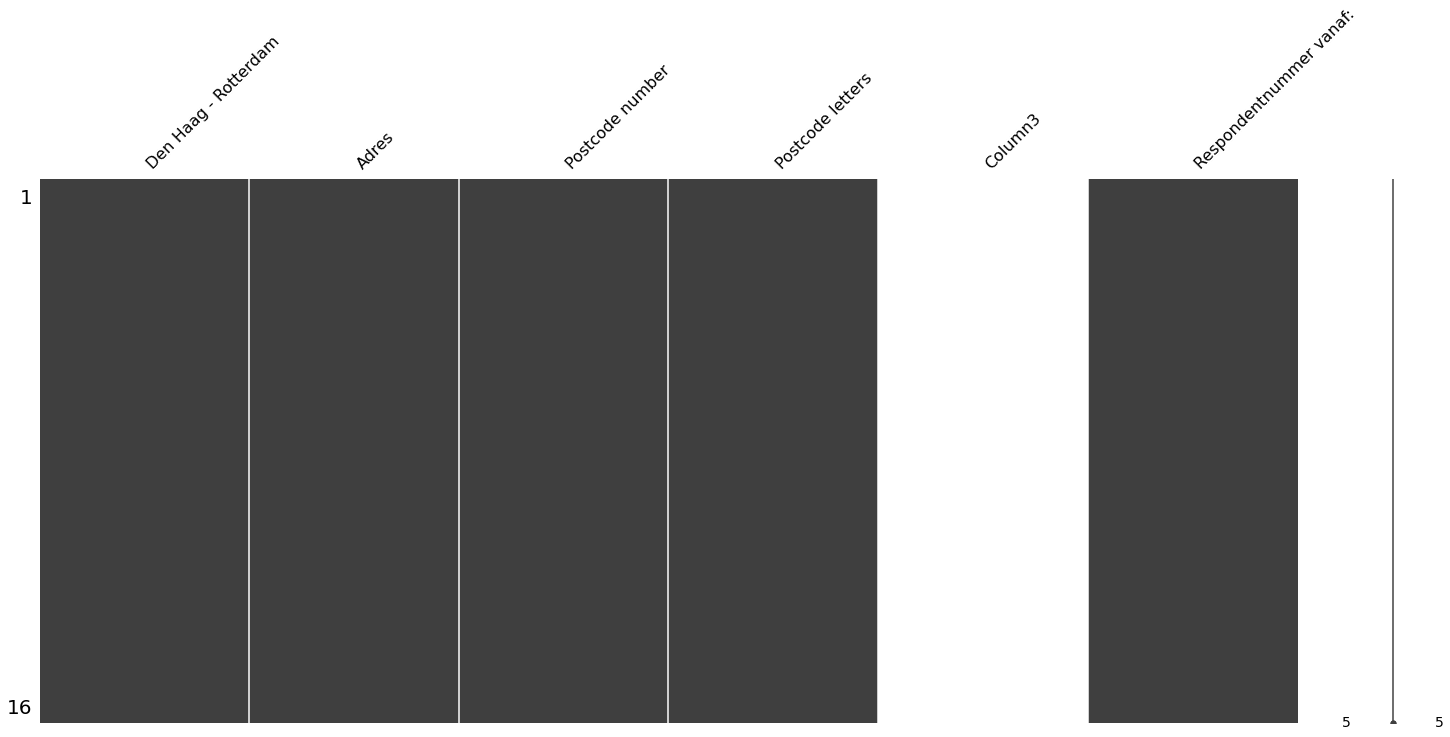

Shape of Dataframe:  (11, 8)

 Dataframe Size:  88
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Groningen                11 non-null     object 
 1   Adres                    11 non-null     object 
 2   Postcode number          11 non-null     int64  
 3   Postcode letters         11 non-null     object 
 4   Column3                  0 non-null      float64
 5   Respondentnummer vanaf:  11 non-null     int64  
 6   Column4                  0 non-null      float64
 7   Column5                  0 non-null      float64
dtypes: float64(3), int64(2), object(3)
memory usage: 832.0+ bytes

 Dataframe Info: 
 None

 Dataframe Head: 
                Groningen                Adres  Postcode number  \
0          OBS Ter Borch  9977 PP Eelderwolde             9977   
1         Schuilingsoord    9472 PA Zuidlaren             9472 

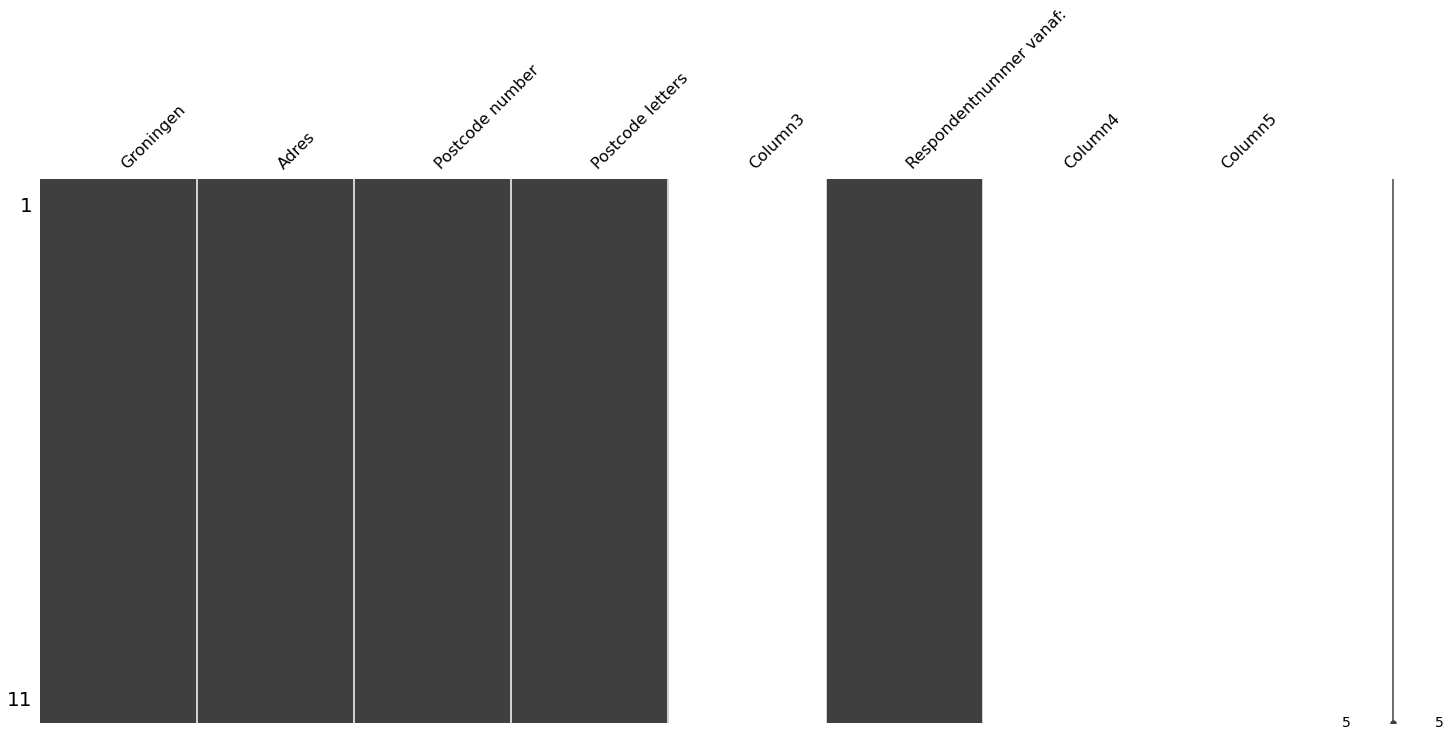

Shape of Dataframe:  (17341, 118)

 Dataframe Size:  2046238
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17341 entries, 0 to 17340
Data columns (total 118 columns):
 #    Column                                    Non-Null Count  Dtype  
---   ------                                    --------------  -----  
 0    ID                                        17341 non-null  int64  
 1    WijkenEnBuurten                           17341 non-null  object 
 2    Gemeentenaam_1                            17341 non-null  object 
 3    SoortRegio_2                              17341 non-null  object 
 4    Codering_3                                17341 non-null  object 
 5    IndelingswijzigingWijkenEnBuurten_4       17341 non-null  object 
 6    AantalInwoners_5                          17341 non-null  int64  
 7    Mannen_6                                  17341 non-null  int64  
 8    Vrouwen_7                                 17341 non-null  int64  
 9    k_0Tot15Jaar_8                 

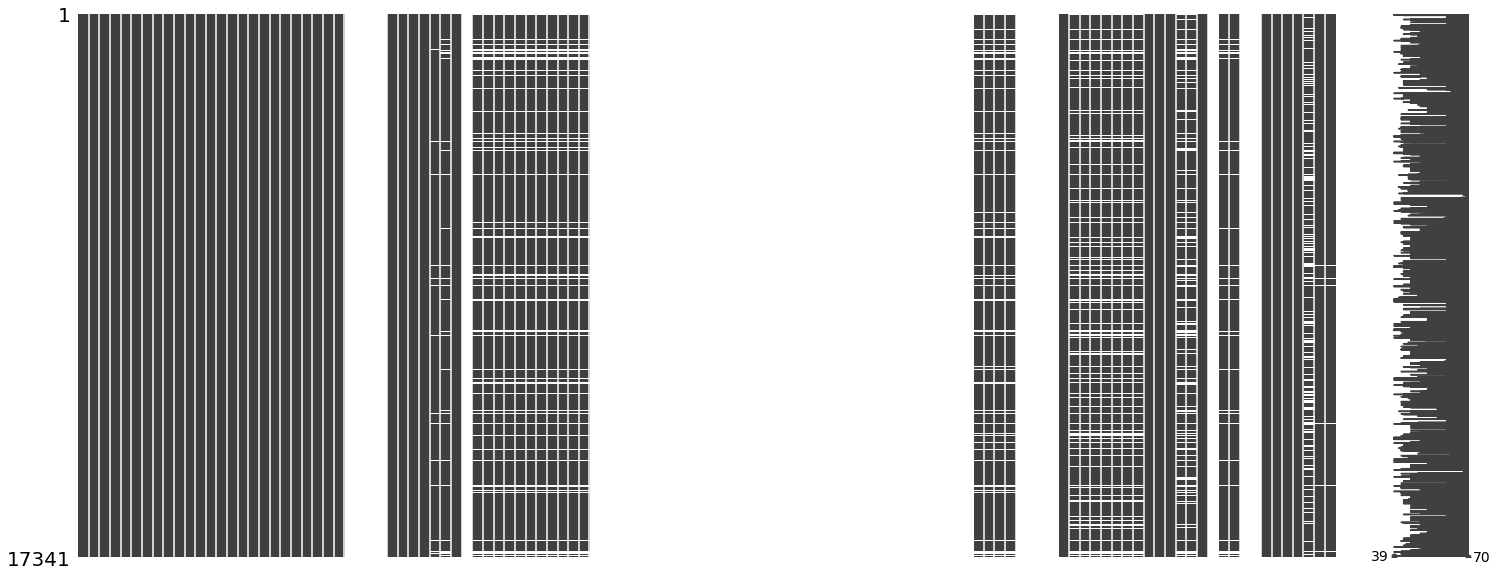

Shape of Dataframe:  (513576, 7)

 Dataframe Size:  3595032
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513576 entries, 0 to 513575
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   513576 non-null  int64  
 1   ID           513576 non-null  int64  
 2   Geslacht     513576 non-null  object 
 3   Leeftijd     513576 non-null  object 
 4   Postcode     513576 non-null  object 
 5   Perioden     513576 non-null  int64  
 6   Bevolking_1  511623 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 27.4+ MB

 Dataframe Info: 
 None

 Dataframe Head: 
    Unnamed: 0  ID                  Geslacht         Leeftijd  \
0          22  22  Totaal mannen en vrouwen  Totaal leeftijd   
1          23  23  Totaal mannen en vrouwen  Totaal leeftijd   
2          46  46  Totaal mannen en vrouwen  Totaal leeftijd   
3          47  47  Totaal mannen en vrouwen  Totaal leeftijd   
4          70  

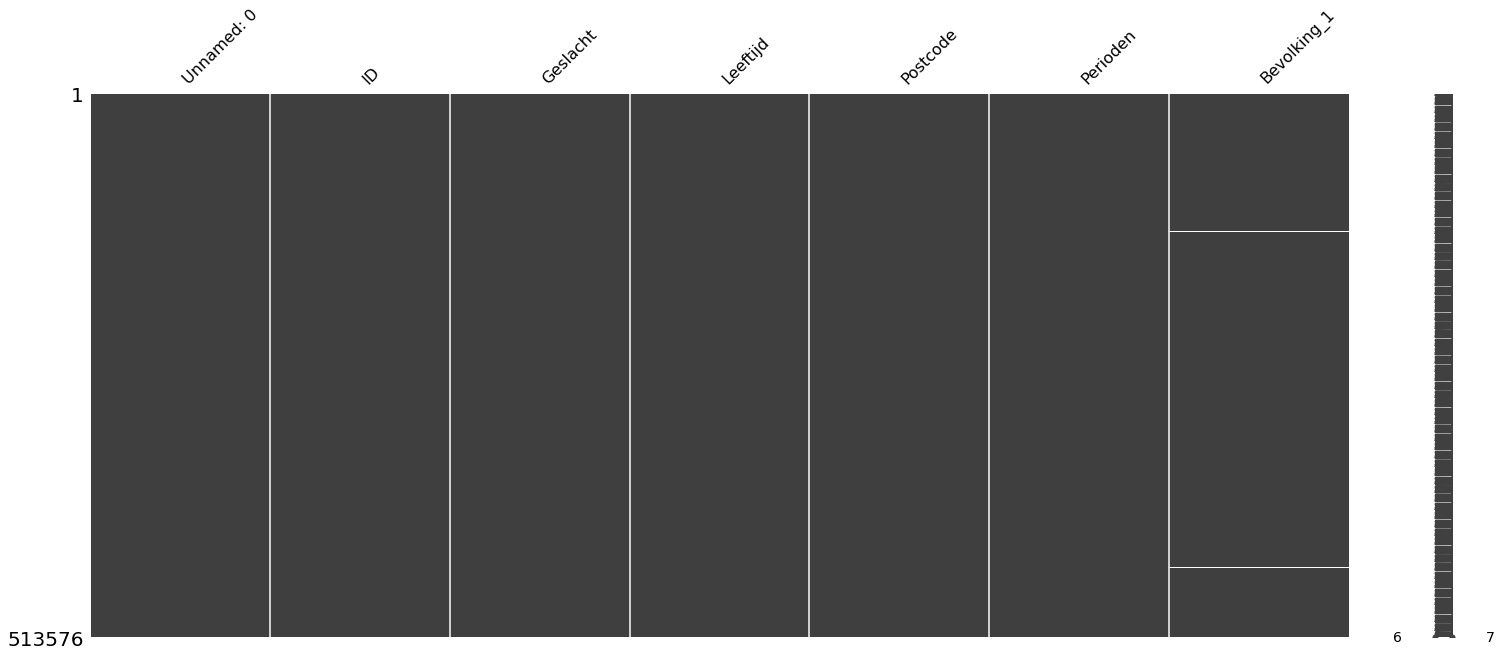

Shape of Dataframe:  (25032, 22)

 Dataframe Size:  550704
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25032 entries, 0 to 25031
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             25032 non-null  int64  
 1   ID                                     25032 non-null  int64  
 2   Populatie                              25032 non-null  object 
 3   KenmerkenVanHuishoudens                25032 non-null  object 
 4   Regio                                  25032 non-null  object 
 5   Perioden                               25032 non-null  int64  
 6   ParticuliereHuishoudens_1              25032 non-null  float64
 7   ParticuliereHuishoudensRelatief_2      25032 non-null  int64  
 8   GemiddeldGestandaardiseerdInkomen_3    15471 non-null  float64
 9   MediaanGestandaardiseerdInkomen_4      18476 non-null  float64
 10  GemiddeldBe

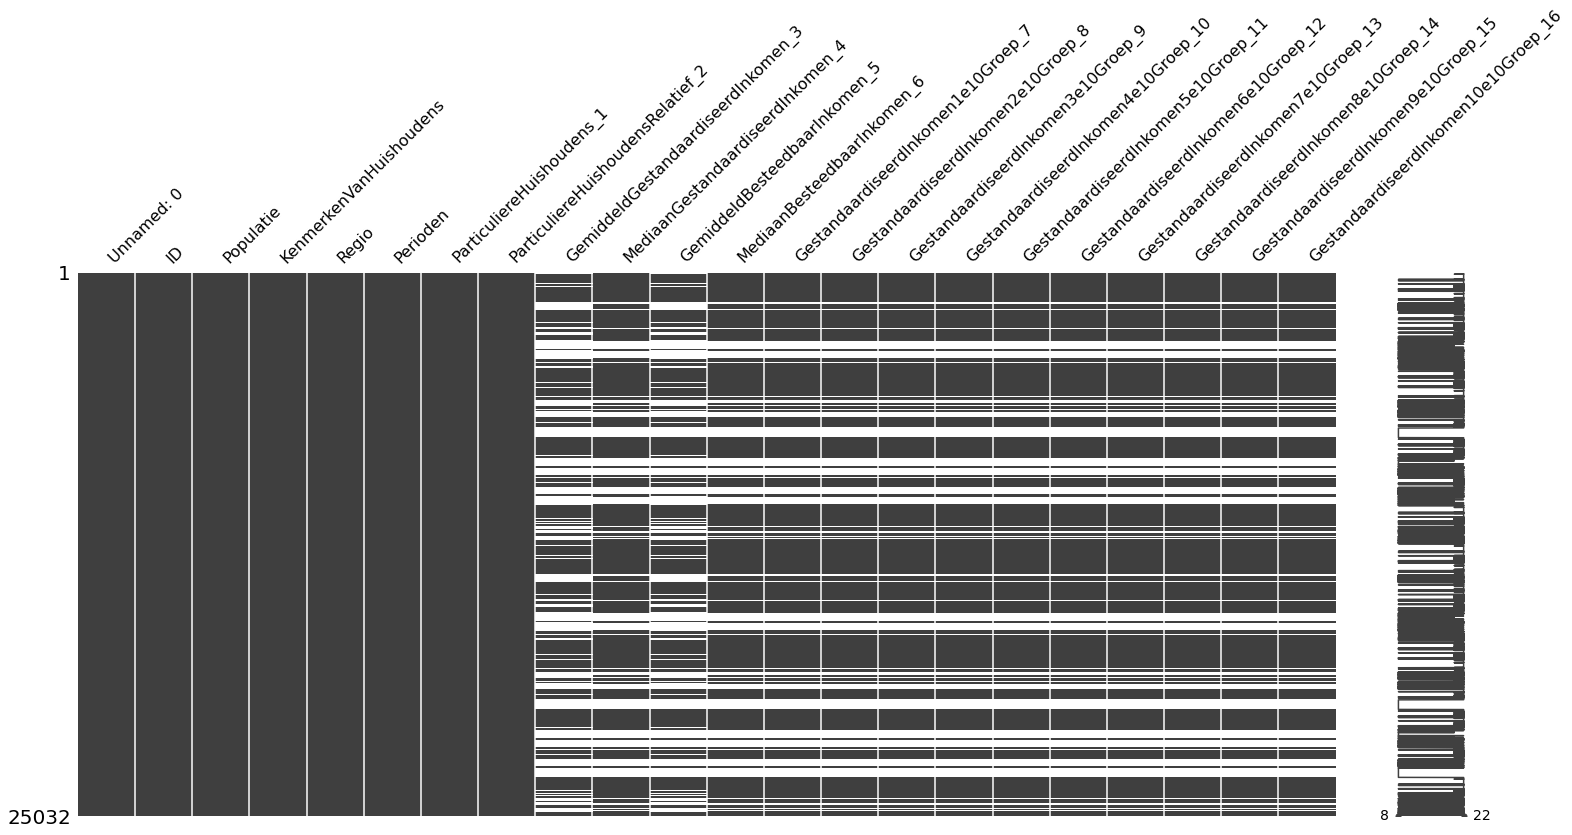

Shape of Dataframe:  (513576, 7)

 Dataframe Size:  3595032
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513576 entries, 0 to 513575
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           513576 non-null  int64  
 1   ID                   513576 non-null  int64  
 2   Geslacht             513576 non-null  object 
 3   Migratieachtergrond  513576 non-null  object 
 4   Postcode             513576 non-null  object 
 5   Perioden             513576 non-null  int64  
 6   Bevolking_1          511623 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 27.4+ MB

 Dataframe Info: 
 None

 Dataframe Head: 
    Unnamed: 0  ID                  Geslacht Migratieachtergrond  \
0          22  22  Totaal mannen en vrouwen              Totaal   
1          23  23  Totaal mannen en vrouwen              Totaal   
2          46  46  Totaal mannen en vrouwen              Totaa

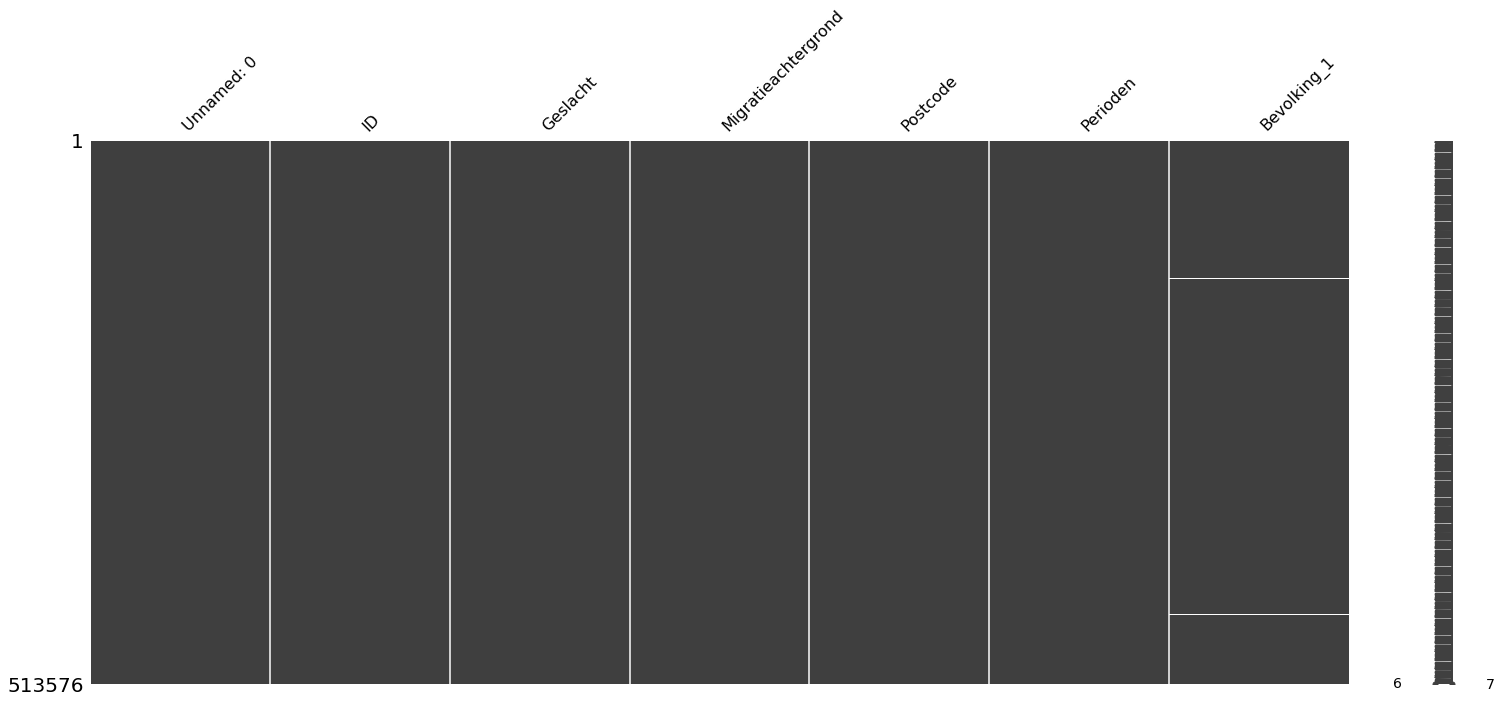

In [535]:
for key in df_dict.keys():
    printDataframeInsights(df_dict[key])
    msno.matrix(df_dict[key])
    plt.savefig('Output-Files/'+key+'_msno.jpg')
    plt.show()

## Cleaning

For cleaning I decided to set the parameters because while experimenting and model evaluation there was just a slight change (0,3%).

In [536]:
percentage = 0.2
missing_vals = np.nan
neighbors = 6
round_option = 0

column_dict_t0 = getGenderAgeBmiColumnNamesDict(t0)
latestAstTestT0 = getNewestASTTest(t0)

t0_cleaned, t0_cleaned_mean_outliers, t0_cleaned_iqr_outliers, t0_cleaned_mean_outliers_wo_nan, t0_cleaned_iqr_outliers_wo_nan = preprocessing(t0, 7, column_dict_t0['Gender'], column_dict_t0['Age'], latestAstTestT0, column_dict_t0['BMI'] )
t0_cleaned.dropna(inplace=True)

Shape of Dataframe:  (1708, 34)

 Dataframe Size:  58072
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708 entries, 0 to 1707
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondentnummer              1708 non-null   int64  
 1   Gender                        1707 non-null   float64
 2   IC                            1708 non-null   int64  
 3   Geboortedatum                 1672 non-null   object 
 4   Leeftijd (op testdag)         1675 non-null   float64
 5   AST (tijd afgerond op 0.1s)   1608 non-null   float64
 6   Opmerkingen                   46 non-null     object 
 7   Lengte (afgerond op 0.1 cm)   1631 non-null   float64
 8   Gewicht (afgerond op 0.1 kg)  1630 non-null   float64
 9   Lengte (in m)                 1631 non-null   float64
 10  BMI                           1630 non-null   float64
 11  Gymles                        1561 non-null   float64
 12  Zweml

## Clean T1 data

As our dataset `t1_eindhoven` has data from t0 and t1 in it we have to split this data into t1 and t0. We can drop t0 here as we already got the eindhoven data in our original `t0`.

In [537]:
t1_eindhoven = searchForDateColumns(t1_eindhoven, '%m/%d/%Y')
t0_eindhoven = t1_eindhoven[t1_eindhoven['Datum_AST'].dt.year == 2020]
t1_eindhoven = t1_eindhoven[t1_eindhoven['Datum_AST'].dt.year == 2021]
t1_eindhoven.reset_index(drop=True, inplace=True)
t1_eindhoven = deletePreviousDataFromDataframe(t1_eindhoven, 'T0')
t1_eindhoven = deletePreviousDataFromDataframe(t1_eindhoven, 'MQ')
t1 = deletePreviousDataFromDataframe(t1, 'MQ')
t1_eindhoven.drop(columns=['Respondentnummer', 'Opmerkingen_picscale','Leeftijd', 'Schoolnummer','Tijdsperiode', 'Klas', 'Datum_AST', 'perc_AST', 'perc_AST_nomissing', 'Opvullers', 'Groep'], inplace=True)
t1_eindhoven.rename(columns={'Respondentnummer_nieuw': 'Respondentnummer', 'Leeftijd_nomissing': 'Leeftijd op testdag', 'LengteinM': 'lengte (m)'}, inplace=True)
t1_eindhoven = convertDatetimeToObject(t1_eindhoven)

Geboortedatum
Geboortedatum_opgevuld_T0
Datum_AST
Geboortedatum


/opt/jupyterhub/anaconda/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_7821/1431843641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[

In [538]:
for col_t0 in t1.columns:
    for col_t1 in t1_eindhoven.columns:
        t1_eindhoven = similar(col_t0, col_t1, t1_eindhoven)

Convert the column types from `t1` to the column type of `t1_eindhoven`.

In [539]:
for col in t1.columns:
    for col_t1 in t1_eindhoven.columns:
        if col == col_t1:
            if not t1[col].dtype == t1_eindhoven[col_t1].dtype:
                t1[col] = t1[col].astype(t1_eindhoven[col_t1].dtype, errors='ignore')

Merge the t1 data from THUAS with t1 data from Eindhoven.

In [540]:
result_t1 = pd.concat([t1, t1_eindhoven])
result_t1.reset_index(drop=True, inplace=True)

As we only need the MQ-Category and MQ-Category binary from t1 for our prediction model every other feature can be dropped.

In [541]:
column_dict_t1 = getGenderAgeBmiColumnNamesDict(result_t1)
latestAstTestt1 = getNewestASTTest(result_t1)
for key in column_dict_t1.keys():
    result_t1 = convertColumnTypes([column_dict_t1[key]], result_t1)
    result_t1 = convertColumnTypes([latestAstTestt1], result_t1)

result_t1 = calculateMQScoreCategoryAndBMICat(result_t1, column_dict_t1['Gender'], column_dict_t1['Age'], latestAstTestt1, column_dict_t1['BMI'])
prediction_df = result_t1[['Respondentnummer', 'MQ category', 'MQ category binary']]
prediction_df.dropna(inplace=True)

/tmp/ipykernel_7821/332119597.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df.dropna(inplace=True)


## Imputation

I tried to find the "best" imputation method and found three different approaches. 
Impute by using the mean.

Impute by using the median.

Impute by using the kNN Imputer from sklearn.

In [543]:
#Statistical imputation
def imputeUsingMedianAndMean(df):
    df_mean = df.copy()
    df_median = df.copy()
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            df_mean[col].fillna(df_mean[col].mean().round(0), inplace=True)
            df_median[col].fillna(df_median[col].median().round(0), inplace=True)
    return df_mean, df_median   

In [544]:
# KNN imputation
def knnImputer(missing_vals, neighbors, copy=True):
    imputer = KNNImputer(missing_values=missing_vals, n_neighbors=neighbors, copy=copy)
    return imputer

In [545]:
def imputeUsingKNN(df, treatMissingValues, neighbors, round_option):
    imputer = knnImputer(treatMissingValues, neighbors)
    imputer.fit(df)
    imputated = np.round(imputer.transform(df), decimals=round_option)
    df_imputed = pd.DataFrame(imputated, columns=df.columns)
    return df_imputed  

In [546]:
t0_cleaned = encodeColumns(t0_cleaned)
t0_cleaned_mean_outliers = encodeColumns(t0_cleaned_mean_outliers)
t0_cleaned_iqr_outliers = encodeColumns(t0_cleaned_iqr_outliers)

In [547]:
t0_cleaned_mean_imputed, t0_cleaned_median_imputed = imputeUsingMedianAndMean(t0_cleaned)
t0_cleaned_knn_imputed = imputeUsingKNN(t0_cleaned, missing_vals, neighbors, round_option)

In [548]:
t0_cleaned_mean_outliers_mean_imputed, t0_cleaned_mean_outliers_median_imputed = imputeUsingMedianAndMean(t0_cleaned_mean_outliers)
t0_cleaned_mean_outliers_knn_imputed = imputeUsingKNN(t0_cleaned_mean_outliers, missing_vals, neighbors, round_option)

In [549]:
t0_cleaned_iqr_outliers_mean_imputed, t0_cleaned_iqr_outliers_median_imputed = imputeUsingMedianAndMean(t0_cleaned_iqr_outliers)
t0_cleaned_iqr_outliers_knn_imputed = imputeUsingKNN(t0_cleaned_iqr_outliers, missing_vals, neighbors, round_option)

### Merge t0 data with postalcode data

In [550]:
t0_cleaned_with_zipcodes, t0_cleaned_zipcodes_wo_nan = mergeDHRotGroZipcodes(t0_cleaned, postcodes_dh_rot, postcodes_gro, 'Respondentnummer', 'Respondentnummer vanaf:', 'Postcode number', 'Postcode letters')

In [551]:
t0_cleaned_with_zipcodes = encodeColumns(t0_cleaned_with_zipcodes)
t0_cleaned_with_zipcodes_mean_imputed, t0_cleaned_with_zipcodes_median_imputed = imputeUsingMedianAndMean(t0_cleaned_with_zipcodes)
t0_cleaned_with_zipcodes_knn_imputed = imputeUsingKNN(t0_cleaned_with_zipcodes, missing_vals, neighbors, round_option)
t0_cleaned_with_zipcodes.dropna(inplace=True)

In [552]:
questionaires.rename(columns={questionaires.columns[0]: t0_cleaned.columns[0]}, inplace=True)
t0_with_questionaires = t0_cleaned.merge(questionaires, how='left', on=t0_cleaned.columns[0])

In [553]:
dfs_for_prediction = {'t0 cleaned': t0_cleaned, 't0 cleaned mean imputed': t0_cleaned_mean_imputed, 't0 median imputed': t0_cleaned_median_imputed, 't0 mean outliers mean imp': t0_cleaned_mean_outliers_mean_imputed, 't0 mean outliers median imp': t0_cleaned_mean_outliers_median_imputed, 't0 mean outliers knn imp': t0_cleaned_mean_outliers_knn_imputed, 't0 zipcodes wo nan': t0_cleaned_with_zipcodes, 't0 zipcodes mean imp': t0_cleaned_with_zipcodes_mean_imputed, 't0 zipcodes median imp': t0_cleaned_with_zipcodes_median_imputed, 't0 zipcodes knn imp': t0_cleaned_with_zipcodes_knn_imputed }

### Data preprocessing
Below is the code I created to preprocess our data. As a few models can't calculate with classification problems (MQ-Category) I had to turn the multiclass classification problem into a multilabel classification problem. This has been done by using the LabelBinarizer from sklearn.

I also do the feature selection in here. We keep only the 5 most valuable features because if we keep less than 5 features we will only end up with the features which are needed for the calculation of the MQ-Category.

In [568]:
for key in dfs_for_prediction.keys():
    print('\n \n KEY: ', key, '\n \n')
    df = encodeColumns(dfs_for_prediction[key])
    lb = LabelBinarizer()
    y = lb.fit_transform(dfs_for_prediction[key]['MQ category'].values)
    X_test, y_test, X_train, y_train,  X_val, y_val, col_names = Split(dfs_for_prediction[key], y, 'MQ category') # Splitting
    X_test_bin, y_test_bin, X_train_bin, y_train_bin, X_val_bin, y_val_bin, col_names_bin = Split(dfs_for_prediction[key], y, 'MQ category binary', True)
    X_cols = X_test.columns.to_list()
    select = SelectKBest(chi2, k=5)
    X_train = select.fit_transform(X_train, y_train)
    filter_X_train = select.get_support()
    X_train_bin = select.fit_transform(X_train_bin, y_train_bin)

    for ind in range(len(filter_X_train)-1 ,0, -1):
    
        if not filter_X_train[ind]:
            X_cols.pop(ind)
    print(X_train.shape)
    print()
    print(X_train_bin.shape)
    print()
    print('5 Best Features: ',X_cols)



 
 KEY:  t0 cleaned 
 

(762, 5)

(762, 5)

5 Best Features:  ['Respondentnummer', 'AST (tijd afgerond op 0.1s)', 'Lengte (afgerond op 0.1 cm)', 'Gewicht (afgerond op 0.1 kg)', 'MQ']

 
 KEY:  t0 cleaned mean imputed 
 

(762, 5)

(762, 5)

5 Best Features:  ['Respondentnummer', 'AST (tijd afgerond op 0.1s)', 'Lengte (afgerond op 0.1 cm)', 'Gewicht (afgerond op 0.1 kg)', 'MQ']

 
 KEY:  t0 median imputed 
 

(762, 5)

(762, 5)

5 Best Features:  ['Respondentnummer', 'AST (tijd afgerond op 0.1s)', 'Lengte (afgerond op 0.1 cm)', 'Gewicht (afgerond op 0.1 kg)', 'MQ']

 
 KEY:  t0 mean outliers mean imp 
 

(1017, 5)

(1017, 5)

5 Best Features:  ['Respondentnummer', 'Geboortedatum', 'AST (tijd afgerond op 0.1s)', 'Lengte (afgerond op 0.1 cm)', 'MQ']

 
 KEY:  t0 mean outliers median imp 
 

(1017, 5)

(1017, 5)

5 Best Features:  ['Respondentnummer', 'Geboortedatum', 'AST (tijd afgerond op 0.1s)', 'Lengte (afgerond op 0.1 cm)', 'MQ']

 
 KEY:  t0 mean outliers knn imp 
 

(1017, 5)

(101